In [1]:
#hide
#skip
%config Completer.use_jedi = False
%config IPCompleter.greedy=True
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
# default_exp fastai.data.block

In [4]:
# export
# Python native modules
import os
from typing import Any,Callable
from inspect import isfunction,ismethod
# Third party libs
from fastcore.all import *
from torch.utils.data.dataloader_experimental import DataLoader2
from fastai.torch_core import *
from fastai.data.transforms import *
import torchdata.datapipes as dp
from collections import deque
from fastai.imports import *
# Local modules
from fastrl.fastai.data.load import *
from fastrl.fastai.data.pipes.core import *
from fastrl.core import *

# Data Block
> High level API to quickly get your data in a `DataLoader`s

## Transform Block

> Note: We will first validate the lower level API on a dqn before making the data block. This is going to be a naive implimentation.

In [5]:
#|export
def _merge_grouper(o):
    if isinstance(o, LambdaType): return id(o)
    elif isinstance(o, type): return o
    elif (isfunction(o) or ismethod(o)): return o.__qualname__
    return o.__class__

def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), _merge_grouper)
    return L(v[-1] for k,v in g.items()).map(instantiate)

def _zip(x): return L(x).zip()

In [6]:
#|export
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, 
        type_tfms:list=None, # One or more `Transform`s for converting types. These will be re-called if workers!=0 for the dataloader.
        item_tfms:list=None, # `ItemTransform`s, applied on an item
        batch_tfms:list=None, # `Transform`s or `RandTransform`s, applied by batch
        cbs:list=None, # `Callback`s for use in dataloaders
        dl_type:DataLoader2=None, # Task specific `TfmdDL`, defaults to `TfmdDL`
        dls_kwargs:dict=None, # Additional arguments to be passed to `DataLoaders`
    ):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  =            L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.cbs        =            L(cbs)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [7]:
# export
def simple_iter_loader_loop(
    items:Iterable,
    cbs:Optional[List[Callback]]=None,
    type_tfms:Optional[Transform]=None,
    item_tfms:Optional[Transform]=None,
    batch_tfms:Optional[Transform]=None,
    bs:int=1,
    n:int=1
):
    pipe = dp.map.SequenceWrapper(items)
    pipe = TypeTransformLoop(pipe, type_tfms=ifnone(type_tfms,L()))
    pipe = dp.map.InMemoryCacheHolder(pipe)
    pipe = dp.iter.MapToIterConverter(pipe) # Will intialize the gym object, which will be an issue when doing multiproc
    pipe = dp.iter.ShardingFilter(pipe)
    pipe = pipe.cycle(count=n)
    pipe = ItemTransformLoop(pipe, item_tfms=ifnone(item_tfms,L()))
    pipe = dp.iter.Batcher(pipe,bs)
    pipe = BatchTransformLoop(pipe, batch_tfms=ifnone(batch_tfms,L()))
    pipe = add_cbs_to_pipes(pipe,cbs)
    return pipe

In [36]:
# export
class DataBlock(object):
    def __init__(
        self,
        blocks:List[TransformBlock]=None, # Transform blocks to use 
        loader_loop:Callable=None,
        dl_type=None
    ):
        store_attr(but='loader_loop')
        self.loader_loop = ifnone(loader_loop,default_loader_loop)
        blocks = L(self.blocks if blocks is None else blocks)
        blocks = L(b() if callable(b) else b for b in blocks)
        self.type_tfms = blocks.attrgot('type_tfms', L())

        self.cbs = blocks.attrgot('cbs', L())
        self.item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        self.batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
        for b in blocks:
            if getattr(b, 'dl_type', None) is not None: self.dl_type = b.dl_type
        if dl_type is not None: self.dl_type = dl_type
        self.dataloaders = delegates(self.dl_type.__init__)(self.dataloaders)
        self.dls_kwargs = merge(*blocks.attrgot('dls_kwargs', {}))

    def datapipes(
        self,
        source:Any,
        bs=1,
        n=1,
        **kwargs,
    ):
        return L(self.loader_loop(
            source,
            cbs=cbs,
            type_tfms=type_tfms,
            item_tfms=self.item_tfms,
            batch_tfms=self.batch_tfms,
            bs=bs,
            n=n,
            **kwargs
        ) for type_tfms,cbs in zip(self.type_tfms,self.cbs))
        
    def dataloaders(
        self,
        source:Any,
        n_workers=0,
        **kwargs
    ):
        pipes = self.datapipes(source,**kwargs)
        return L(pipes).map(DataLoader2,num_workers=n_workers,**self.dls_kwargs)

## Example

In [37]:
# export
import gym



class NSkipPipe(dp.iter.IterDataPipe):
    
    def __init__(self, source_datapipe, n=1, **kwargs) -> None:
        self.source_datapipe = source_datapipe
        self.n = n
        self.kwargs = kwargs
    
    def __iter__(self):
        skip_idx = 0
        for o in self.source_datapipe:
            if not type(o)==dict:
                raise Exception(f'Expected dict object generated from `make_step` got {type(o)}\n{o}')
            
            skip_idx += 1 # Be aware of the ordering here. we want to always show the first step when we can. 
            if skip_idx%self.n==0 or o['done']: 
                yield o
                if o['done']: skip_idx = 0

In [38]:
# export

class NStepCallback(Callback):
    def __init__(self,nsteps=1,nskip=1):
        store_attr()

    def add_nstep_pipes(self,before=None,after=ItemTransformLoop,not_under=None) -> List[dp.iter.IterDataPipe]:
        return L(partial(NSkipPipe,n=self.nskip),
                 partial(NStepPipe, n=self.nsteps),
                 Flattener
               )

In [39]:
# export
class DictCollate(Transform):
    def encodes(self,o): return L(o).map(BD).sum()
    
class DictToTensor(Transform):
    def encodes(self,o:dict):
        for k,v in o.items(): 
            v = TensorBatch(v)
            if len(v.shape)==0: v = v.unsqueeze(0)
            o[k] = v
        return o

In [72]:
# export

class GymTypeTransform(Transform):
    def encodes(self,o): return gym.make(o)
    
class GymStepTransform(Transform):
    @delegates(Transform)
    def __init__(self,agent=None,**kwargs):
        self.agent = agent
        super().__init__(**kwargs)
    
    def encodes(self,o:gym.Env):
        
        if getattr(o,'is_done',True):
            state = o.reset(seed=getattr(self,'seed',0))
            o.is_done = False
            o.sum_reward = 0
            episode_n = getattr(o,'step_info',{'episode_n':-1})['episode_n']+1
            o.step_info = make_step(state,None,False,None,0,None,env_id=id(o),step_n=-1,
                                    episode_n=episode_n)
        else:
            state = o.state
            
        self.agent.agent_base.iterator.append(o.step_info)
        for action in self.agent:
            next_state,reward,done,_ = o.step(action)
            o.sum_reward += reward
        
        if done: o.is_done = True
        o.step_info = make_step(state,next_state,done,reward,o.sum_reward,action,env_id=id(o),
                                step_n=o.step_info['step_n']+1,episode_n=o.step_info['episode_n'])
        
        return o.step_info
    


In [73]:
# export
from torch.nn import *
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

class DQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)

class Agent(dp.iter.IterDataPipe):
    def __init__(self,model,iterator):
        self.model = model
        self.iterator = iterator
        self.agent_base = self
        
    def __iter__(self):
        while self.iterator:
            yield self.iterator.pop(0)


class RawOutOfStep(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,agent_base,key): 
        self.source_datapipe = source_datapipe
        self.key = key
        self.agent_base = agent_base
        
    def __iter__(self):
        for o in self.source_datapipe:
            x = tensor(o[self.key])
            x = self.agent_base.model(x)
            yield x
            
class ArgmaxOfStep(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,agent_base): 
        self.source_datapipe = source_datapipe
        self.agent_base = agent_base
        
    def __iter__(self):
        for o in self.source_datapipe:
            yield torch.argmax(o)
            
class ToDiscrete(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,agent_base): 
        self.source_datapipe = source_datapipe
        self.agent_base = agent_base
        
    def __iter__(self):
        for x in self.source_datapipe:
            if isinstance(x,Tensor):
                if len(x.shape)==0:
                    yield int(x)
                else:
                    yield x.long()
            else:
                raise Exception(f'Cant convert to discrete: {x}')

In [74]:
# export
class DiscreteEpsilonRandomSelect(dp.iter.IterDataPipe):
    debug=False
    def __init__(self,source_datapipe,agent_base,n_actions,idx=0,min_epsilon=0.2,max_epsilon=1,max_steps=5000):
        self.n_actions = n_actions
        self.source_datapipe = source_datapipe
        self.agent_base = agent_base
        self.agent_base.epislon_selector = self 
        self.min_epsilon = min_epsilon
        self.epsilon = max_epsilon
        self.max_epsilon = max_epsilon
        self.max_steps = max_steps
        self.idx = idx
    
    def __iter__(self):
        for action in self.source_datapipe:
            mask = np.random.random(size=self.n_actions) < self.epsilon
            rand_actions = np.random.choice(self.n_actions, sum(mask))
            action = action.cpu().detach().numpy().reshape((-1,))
            action[mask] = rand_actions
            action=Tensor(action).long().reshape(-1,1)

            if self.agent_base.model.training: 
                self.idx += 1
                self.epsilon = max(self.min_epsilon,self.max_epsilon-self.idx/self.max_steps)
            yield action

In [75]:
test_info = dict(state=np.random.sample((1,4)),
                 next_state=np.random.sample((1,4)),
                 action=np.random.sample((1,4)))

In [76]:
model = DQN(4,2)
agent_base = Agent(model,[test_info])
agent = RawOutOfStep(agent_base,agent_base,'state')
agent = DiscreteEpsilonRandomSelect(agent,agent_base,2,min_epsilon=0)
agent = ArgmaxOfStep(agent,agent_base)
agent = ToDiscrete(agent,agent_base)

In [77]:
for i,action in enumerate(agent):
    test_info = dict(state=np.random.sample((1,4)),
                 next_state=np.random.sample((1,4)),
                 action=np.random.sample((1,4)))
    agent.agent_base.iterator.append(test_info)
    if i%200==0:print(action,agent_base.epislon_selector.epsilon)
    if i>7000: break

0 0.9998
1 0.9598
0 0.9198
0 0.8798
0 0.8398
0 0.7998000000000001
1 0.7598
0 0.7198
1 0.6798
0 0.6397999999999999
0 0.5998
1 0.5598000000000001
0 0.5198
0 0.4798
0 0.43979999999999997
0 0.39980000000000004
0 0.3598
0 0.3198
0 0.27980000000000005
0 0.2398
0 0.19979999999999998
0 0.15980000000000005
0 0.11980000000000002
0 0.07979999999999998
0 0.03979999999999995
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [78]:
test_info = dict(state=np.random.sample((1,4)),
                 next_state=np.random.sample((1,4)),
                 action=np.random.sample((1,4)))
agent.agent_base.iterator.append(test_info)

In [81]:

GymTransformBlock = TransformBlock(
    type_tfms  = GymTypeTransform,
    item_tfms  = (GymStepTransform(agent),DictToTensor),
    batch_tfms = DictCollate,
    cbs = NStepCallback(nsteps=1)
)

block = DataBlock(
    blocks = GymTransformBlock,
    loader_loop=simple_iter_loader_loop
)
pipes = block.datapipes(['CartPole-v1']*1,n=10,bs=1)

In [82]:
dls = block.dataloaders(['CartPole-v1']*1,n=40,n_workers=0)

In [83]:
# from pprint import pprint
for o in dls[0]:
    print(o['state'],o['step_n'],o['done'],o['episode_n'])
    

TensorBatch([[ 0.0137, -0.0230, -0.0459, -0.0483]]) TensorBatch([[0]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[ 6.4906e-04, -6.0638e-01, -3.2139e-02,  7.8611e-01]]) TensorBatch([[1]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.0115, -0.8010, -0.0164,  1.0685]]) TensorBatch([[2]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.0275, -0.9959,  0.0050,  1.3560]]) TensorBatch([[3]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.0474, -1.1911,  0.0321,  1.6502]]) TensorBatch([[4]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.0712, -1.3866,  0.0651,  1.9527]]) TensorBatch([[5]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.0990, -1.5824,  0.1041,  2.2648]]) TensorBatch([[6]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.1306, -1.7783,  0.1494,  2.5877]]) TensorBatch([[7]]) TensorBatch([[False]]) TensorBatch([[0]])
TensorBatch([[-0.1662, -1.9742,  0.2012,  2.9221]]) TensorBatch([[8]]) TensorBat

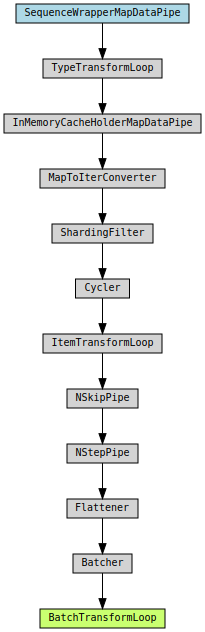

In [84]:
from torch.utils.data.graph import traverse
from torchdata.datapipes.utils import to_graph
to_graph(pipes[0])

In [85]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbdev.cli import *
    make_readme()
    notebook2script(silent=True)

converting /home/fastrl_user/fastrl/nbs/index.ipynb to README.md
